In [21]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

order_num = pd.read_csv('order_num.csv')
monthly = pd.read_csv('monthly_deliver.csv') 
weekly = pd.read_csv('weekly_delivery.csv')
avg_revenue = pd.read_csv('avg_revenue_by_order_num.csv')
weekly_retention = pd.read_csv('weekly_retention.csv')
weekly_sale = pd.read_csv('weekly_sales.csv')
weekly_profit = pd.read_csv('weekly_profit.csv')

### Weekly Revenue and Profit 
Measure sales and profit every week to see if the app is steadily growing.

#### SQL code to get the weekly_sale data
```sql
SELECT 
    DATE_TRUNC('week',o.order_date) as week,
    SUM(m.meal_price * o.order_quantity) as revenue
FROM meals as m 
JOIN orders as o
ON m.meal_id = o.meal_id
GROUP BY week
ORDER BY week ASC;


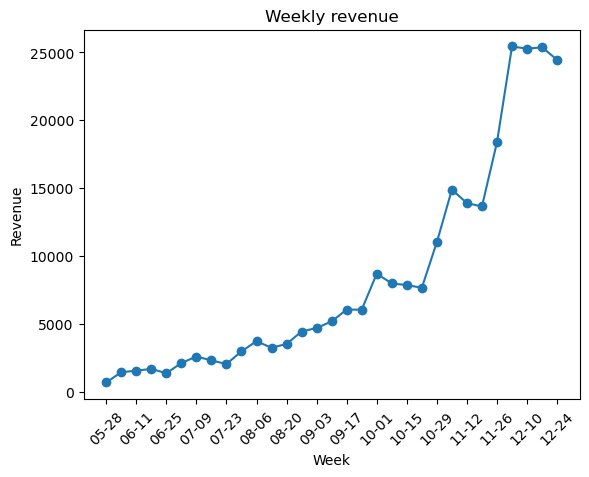

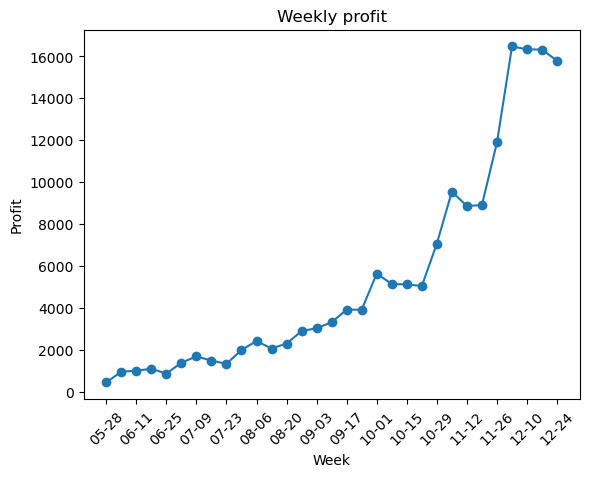

In [ ]:
# Format weekly data and convert to month-day format to prepare plots
weekly_sale['week'] = pd.to_datetime(weekly_sale['week'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
weekly_sale['week'] = weekly_sale['week'].dt.strftime('%m-%d')

weekly_profit['week'] = pd.to_datetime(weekly_profit['week'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
weekly_profit['week'] = weekly_profit['week'].dt.strftime('%m-%d')
weekly_profit = weekly_profit.sort_values('week', ascending=True).reset_index(drop=True)

plt.plot(weekly_sale['week'],weekly_sale['revenue'],marker='o')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.title('Weekly revenue')
plt.xticks(ticks = range(0, len(weekly_sale['week']),2),rotation=45)
plt.show()

plt.plot(weekly_profit['week'],weekly_profit['profit'],marker='o')
plt.xlabel('Week')
plt.ylabel('Profit')
plt.title('Weekly profit')
plt.xticks(ticks = range(0, len(weekly_profit['week']),2),rotation=45)
plt.show()

## Insight 
Both weekly sales and profits are growing steadily, indicating that the market is expanding.
Further analysis of the factors that influence the rapid expansion of sales and profits will be beneficial. 

## Profit margin by meal
In order to determine which dish is more profitable for the business and to improve it, the profit margin must be calculated for each dish.

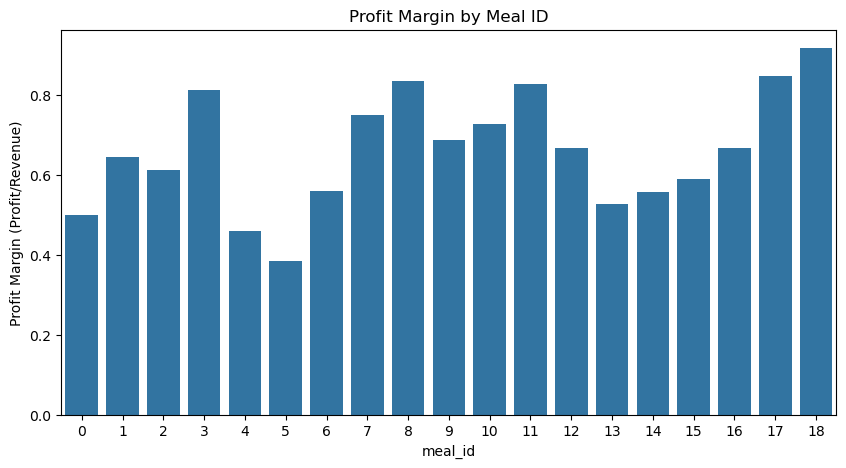

In [23]:
profit = pd.read_csv('profit_items.csv')
profit['profit_margin'] = profit['profit'] / profit['revenue']
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='meal_id', y='profit_margin', data=profit)
ax.set_title('Profit Margin by Meal ID')
ax.set_ylabel('Profit Margin (Profit/Revenue)')
plt.show()

## Insight
According to this chart, meal ID 18 has the highest margin, followed by meal IDs 3 and 17, and meal ID 4 and 5  have  relatively lower margin than average.
It is desirable to investigate the causes of low-margin dishes (meal id 4 and 5) and to improve them and to sell more high-margin dishes (meal id 17 and 18).

## Week-by-week order quantity and profit
The purpose is to determine the number of orders per day of the week and profit, and to analyze whether the day of the week has an impact on app usage.

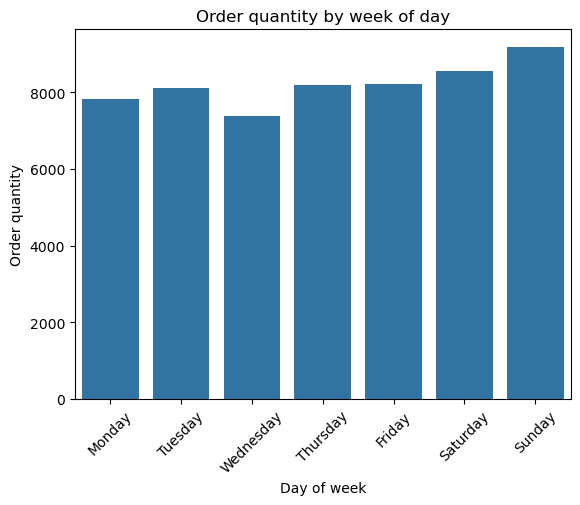

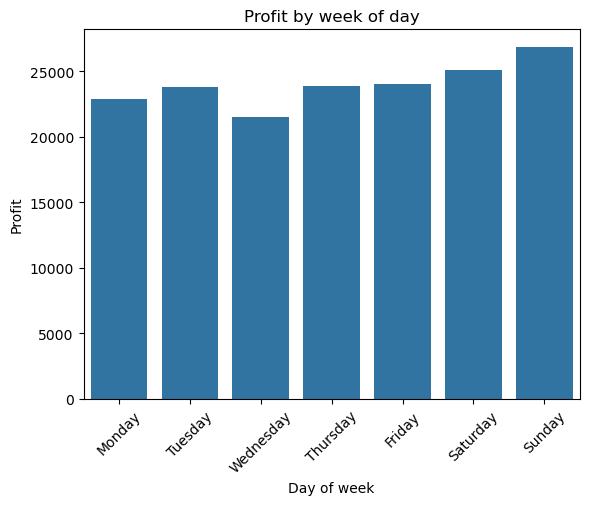

In [24]:
weekday = pd.read_csv('order_meal_merged.csv')
weekday['order_date'] = pd.to_datetime(weekday['order_date'])
weekday['day_name'] = weekday['order_date'].dt.day_name()
weekday['profit'] = (weekday['meal_price'] - weekday['meal_cost']) * weekday['order_quantity']
weekday['order_num'] = weekday['order_quantity'].count
weekday_profit = weekday.groupby('day_name')[['order_quantity','profit']].sum()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_profit = weekday_profit.reindex(day_order)

sns.barplot(x= 'day_name', y='order_quantity', data = weekday_profit)
plt.xlabel('Day of week')
plt.ylabel('Order quantity')
plt.title('Order quantity by week of day')
plt.xticks(rotation = 45)
plt.show()

sns.barplot(x= 'day_name', y='profit', data = weekday_profit)
plt.xlabel('Day of week')
plt.ylabel('Profit')
plt.title('Profit by week of day')
plt.xticks(rotation = 45)
plt.show()



## Insight
The day of the week did not have a significant impact on the number of orders and profits, but it looks that both orders and profits are slightly higher on weekends than on weekdays.

## Users' total number of orders
The purpose of this section is to get an aggregate count regarding the number of times a user has placed an order. 


### SQL code to get the order_num data
```sql
WITH order_count as (
    select 
        o.user_id,
        COUNT(distinct o.order_id ) as orders,
        avg(m.meal_price * o.order_quantity) as revenue 
    from orders as o
    join meals as m 
    on m.meal_id = o.meal_id
    group by o.user_id
)
select 
    orders,
    avg(revenue) as avg_revenue
from order_count
group by orders
ORDER BY orders;

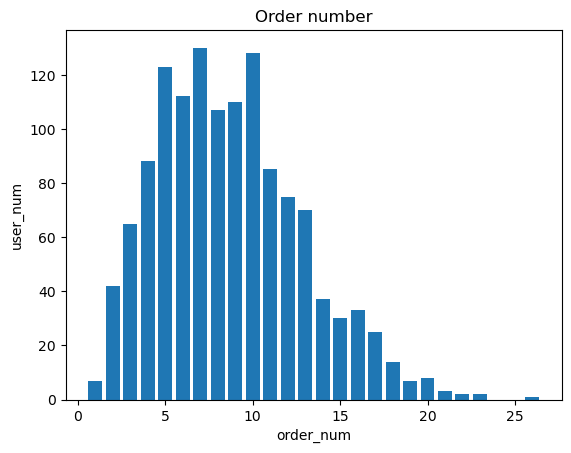

In [25]:
plt.bar(order_num['orders'], order_num['users'])
plt.xlabel('order_num')
plt.ylabel('user_num')
plt.title('Order number')
plt.show()

## insight
This graph suggests that the app has a high number of users who make occasional purchases, while a smaller number of them are more frequent ordered.


## Weekly Retention Rate 
The purpose of this section is to find the retention rate compared to last week to see if the app is continuing to attract users.


### SQL code to get the weekly_retention data
``` sql
WITH user_weekly_activity AS (
  SELECT DISTINCT
    DATE_TRUNC('week', order_date) :: DATE AS week,
    user_id
  FROM orders)

SELECT
  previous.week,
  ROUND(
    COUNT(distinct current.user_id) :: numeric /
    GREATEST(COUNT(DISTINCT previous.user_id), 1), -- avoid dividing by 0 
  2) AS retention_rate
FROM user_weekly_activity AS previous
LEFT JOIN user_weekly_activity AS current
ON current.user_id = previous.user_id
AND previous.week = (current.week -INTERVAL'1 week')
GROUP BY previous.week
ORDER BY previous.week ASC;

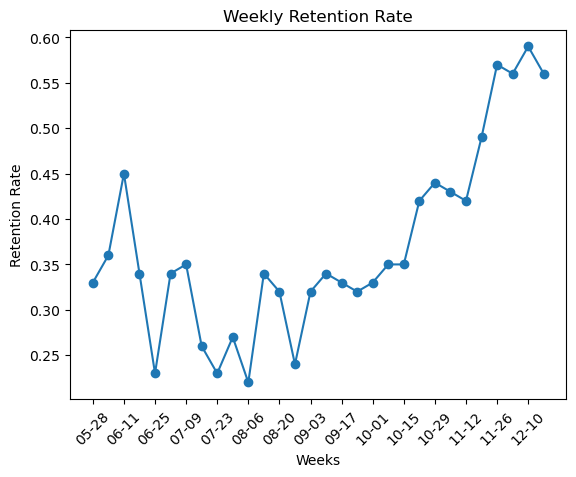

In [26]:
# retention rate 
weekly_retention['week'] = pd.to_datetime(weekly_retention['week'], format='%Y-%m-%d', utc=True)
weekly_retention = weekly_retention[weekly_retention['week'] != '2018-12-24']
weekly_retention['week'] = weekly_retention['week'].dt.strftime('%m-%d')

plt.plot(weekly_retention['week'],weekly_retention['retention_rate'],marker ='o')
plt.xlabel('Weeks')
plt.ylabel('Retention Rate')
plt.title('Weekly Retention Rate')
plt.xticks(ticks = range(0, len(weekly_retention['week']),2), rotation =45)
plt.show()

## insight
The overall trend seems to be increasing. However, some weeks showing a significant drop. This could be due to various factors such as seasonal trends, marketing campaigns, or product updates. 

## Weekly ARPU (Average Revenue Per User)
The purpose of this section is to determine the average revenue per user of the app and seek to see if it is achieving an efficient business model.

### SQL code to get the weekly data
```sql
WITH arpu as(
    SELECT 
        DATE_TRUNC('week',order_date) as week,
        SUM(m.meal_price * o.order_quantity) as total_revenue,
        COUNT(DISTINCT o.user_id) as total_users,
        ROUND(
            SUM(m.meal_price * o.order_quantity) :: numeric / COUNT(DISTINCT o.user_id)
            ,2) as ARPU
    FROM meals as m  
    JOIN orders as o 
    ON m.meal_id = o.meal_id
    group BY DATE_TRUNC('week',o.order_date)
)
SELECT 
    week,
    ARPU
FROM arpu
ORDER BY week;


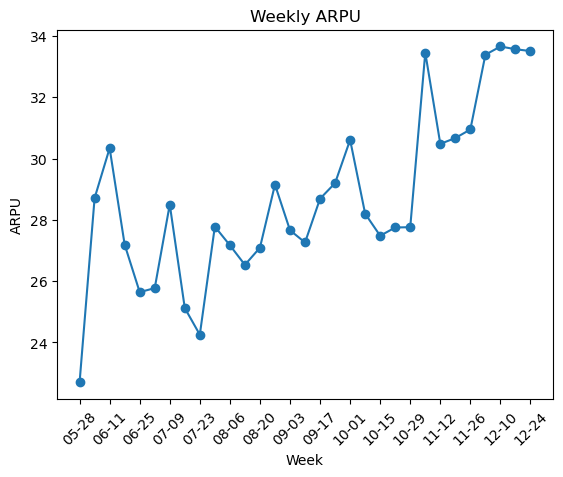

In [27]:
weekly['week'] = pd.to_datetime(weekly['week'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
weekly['week'] = weekly['week'].dt.strftime('%m-%d')

# plot linechart 
plt.plot(weekly['week'], weekly['arpu'], marker='o')
plt.xlabel('Week')
plt.ylabel('ARPU')
plt.title('Weekly ARPU')
plt.xticks(ticks = range(0, len(weekly['week']),2),rotation=45)
plt.show()

## Insight

Although ARPU generally increases over time, the trend isn't constant, with a sharp increase from late October to November, and noticeable decreases in mid-June, July and September. Further analysis is needed to determine whether these fluctuations are seasonal or influenced by other factors.